In [81]:
%matplotlib inline

In [52]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
device

device(type='cuda')

In [54]:
SOS_token = 0
EOS_token = 1
class Lang:
    def __init__(self, name= r'eng'):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [55]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s, rus = False):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"([\s+])", r" ", s)
    if rus:
        s = re.sub(r"[^а-яА-ЯёЁ.!?]+", r" ", s)
    else:
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    if lang2 is not None:
        lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
        pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    else:
        lines = open('data/%s.txt' % (lang1), encoding='utf-8').read().strip().split('\n')
        lines = [[s for i, s in enumerate(l.split('\t')) if i in [0,1] ] for l in lines]
        pairs = [[ normalizeString(l[0]),normalizeString(l[1], rus=True) ] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

In [56]:
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2 =None, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [57]:
input_lang, output_lang, pairs = prepareData('rus', None, True)

Reading lines...
Read 496059 sentence pairs
Trimmed to 28719 sentence pairs
Counting words...
Counted words:
None 10174
rus 4303


In [11]:
pairs[-5]

['она улыбнулась в ответ на его нежныи взгляд .',
 'she smiled in response to his affectionate glance .']

# The Encoder

In [59]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [60]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [61]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [62]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [63]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\49074703.py:15: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend('agg')


In [64]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [65]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [66]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [67]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 3s (- 14m 52s) (5000 6%) 3.0774
2m 1s (- 13m 12s) (10000 13%) 2.5843
3m 0s (- 12m 2s) (15000 20%) 2.3110
3m 58s (- 10m 57s) (20000 26%) 2.1369
4m 57s (- 9m 54s) (25000 33%) 1.9868
5m 55s (- 8m 53s) (30000 40%) 1.8469
6m 53s (- 7m 52s) (35000 46%) 1.7400
7m 53s (- 6m 54s) (40000 53%) 1.6686
8m 53s (- 5m 55s) (45000 60%) 1.5874
9m 52s (- 4m 56s) (50000 66%) 1.4985
10m 51s (- 3m 57s) (55000 73%) 1.4394
11m 49s (- 2m 57s) (60000 80%) 1.4046
12m 47s (- 1m 58s) (65000 86%) 1.3602
13m 45s (- 0m 58s) (70000 93%) 1.2932
14m 43s (- 0m 0s) (75000 100%) 1.2728


In [68]:
evaluateRandomly(encoder1, attn_decoder1)

> они как семья .
= they re like family .
< they re like a family . <EOS>

> я рад что пошел .
= i m glad that i went .
< i m glad glad was . <EOS>

> ты сеичас сердишься .
= you re angry now .
< you re now now . <EOS>

> вы мои гости .
= you re my guests .
< you re my neighbor . <EOS>

> я ужасныи человек .
= i m a horrible person .
< i m a honest man . <EOS>

> сегодня вечером ты необычаино разговорчив .
= you re unusually talkative tonight .
< you re free to be up up . <EOS>

> я уверен что кто нибудь это сделает .
= i m sure that somebody will do it .
< i m sure that will do that that it .

> в какои то степени вы правы .
= you are right to a certain extent .
< you are the right person right . <EOS>

> вы сильныи .
= you are strong .
< you re strong . <EOS>

> я конечно шучу .
= i m kidding of course .
< i m kidding of . <EOS>



In [76]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "я рада что вы не мертвы .")
plt.matshow(attentions.numpy())
plt.show()

C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2311955677.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Внимание на базе скалярного протизведения 
Скалярное произведение расчитывается между векторов эмбединга и скрытым состоянием ( запросом q и ключом k) torch.tensordot(embedded, hidden)


In [42]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [43]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.tensordot(embedded, hidden)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [44]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 3s (- 14m 54s) (5000 6%) 3.1219
2m 4s (- 13m 30s) (10000 13%) 2.6033
3m 6s (- 12m 24s) (15000 20%) 2.3779
4m 6s (- 11m 16s) (20000 26%) 2.2261
5m 5s (- 10m 10s) (25000 33%) 2.0624
6m 4s (- 9m 6s) (30000 40%) 1.9575
7m 3s (- 8m 4s) (35000 46%) 2.0468
8m 3s (- 7m 2s) (40000 53%) 1.9261
9m 6s (- 6m 4s) (45000 60%) 1.8569
10m 9s (- 5m 4s) (50000 66%) 1.7831
11m 12s (- 4m 4s) (55000 73%) 1.7035
12m 14s (- 3m 3s) (60000 80%) 1.6755
13m 14s (- 2m 2s) (65000 86%) 1.6233
14m 13s (- 1m 0s) (70000 93%) 1.5522
15m 12s (- 0m 0s) (75000 100%) 1.4898


In [45]:
evaluateRandomly(encoder1, attn_decoder1)

> мы едим помидоры .
= we re eating tomatoes .
< we re about the . . <EOS>

> ты вдвое старше меня .
= you re twice as old as i am .
< you re twice as old as me . <EOS>

> я стараюсь быть искреннеи .
= i m trying to be sincere .
< i m trying to be a . <EOS>

> мы здесь для того чтобы тебя защитить .
= we re here to protect you .
< we re here to be here you . <EOS>

> мы пытаемся выиграть .
= we re trying to win .
< we re trying to win . <EOS>

> я рад что том благополучно добрался до дома .
= i m glad that tom got home safely .
< i m glad tom left home home . <EOS>

> ты везунчик .
= you re the lucky one .
< you re a . <EOS>

> ты идеален .
= you re perfect .
< you re perfect . <EOS>

> вы бедны .
= you re poor .
< you re odd . <EOS>

> я так рад что вы все здесь .
= i m so glad you are all here .
< i m so glad you re here . <EOS>



# Внимание на базе MLP (однослойной сети)
для каждого параметра эмбединга (запроса q) и скрытого состояния ( ключ k) 

In [77]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [78]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_q = nn.Linear(self.hidden_size * 1, self.max_length, bias=False)
        self.attn_k = nn.Linear(self.hidden_size * 1, self.max_length, bias=False)

        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(F.tanh( self.attn_q(embedded[0]) + self.attn_k(hidden[0])))        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [79]:
hidden_size = 256
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder3, 75000, print_every=5000)

C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2856552015.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(F.tanh( self.attn_q(embedded[0]) + self.attn_k(hidden[0])))


1m 4s (- 15m 3s) (5000 6%) 3.1358
2m 6s (- 13m 41s) (10000 13%) 2.6013
3m 6s (- 12m 27s) (15000 20%) 2.3874
4m 6s (- 11m 18s) (20000 26%) 2.1769
5m 6s (- 10m 13s) (25000 33%) 2.0061
6m 7s (- 9m 11s) (30000 40%) 1.8947
7m 7s (- 8m 8s) (35000 46%) 1.8012
8m 7s (- 7m 6s) (40000 53%) 1.7244
9m 8s (- 6m 5s) (45000 60%) 1.6302
10m 9s (- 5m 4s) (50000 66%) 1.5384
11m 12s (- 4m 4s) (55000 73%) 1.4711
12m 12s (- 3m 3s) (60000 80%) 1.4287
13m 12s (- 2m 1s) (65000 86%) 1.3975
14m 13s (- 1m 0s) (70000 93%) 1.3010
15m 15s (- 0m 0s) (75000 100%) 1.2835


C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2856552015.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(F.tanh( self.attn_q(embedded[0]) + self.attn_k(hidden[0])))


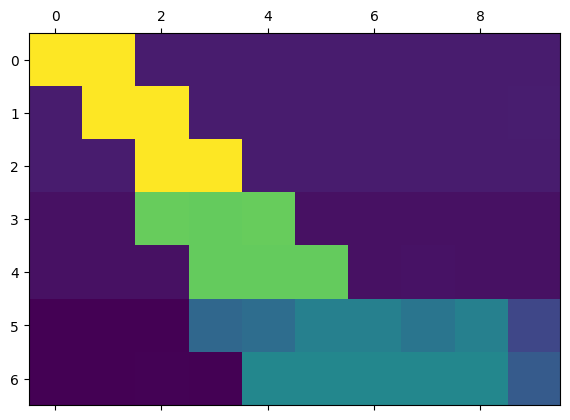

In [85]:
output_words, attentions = evaluate(encoder3, attn_decoder3, "мы пытаемся выиграть .")
plt.matshow(attentions.numpy())
plt.show()

input = мы пытаемся выиграть .
output = we re trying to win . <EOS>


C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2856552015.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = F.softmax(F.tanh( self.attn_q(embedded[0]) + self.attn_k(hidden[0])))
C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2078729963.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\daimond025\AppData\Local\Temp\ipykernel_217608\2078729963.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


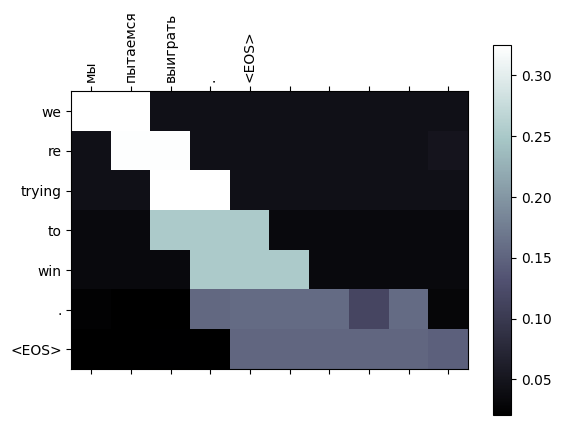

In [87]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder3, attn_decoder3, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("мы пытаемся выиграть .")

#  Вывод 
- построена архитектура внимания
- вычеслены веса внимания на основе
  - соединения эмбединга и скрытого состояния (ошибка 1.27)
  - скалярного произведения эмбединга и скрытого состояния (ошибка 1.48)
  - основе MLP (ошибка 1.28)

Видно что MPL работает лучше чем скалярное произведение